# Übung 02 - Multi-Channel Rekonstruktion

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
# import sys
# sys.path.append('..')
import helper

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In der letzten Übung haben Sie den k-Raum und die Bildrekonstruktion mittels der iFFT kennengelernt. Die Daten, die Sie dabei verwendet haben, sind aber nicht nur deshalb unrealistisch, weil es sich um Phantom-Daten handelt, sondern auch, weil es nur eine Spule gab, die alle Daten perfekt aufnehmen konnte. In der Realität nutzt man allerdings immer mehrere Spulen und das Bild entsteht erst durch Kombination der Daten, die von den einzelnen Spulen erfasst wurden.
Dies soll in den folgenden Aufgaben vertieft werden.

## Aufgabe 1

Laden Sie die Datei "phantom_8channel_256x256.npy" aus Stud.IP herunter und platzieren Sie diese im selben Ordner, wie dieses Notebook. Führen Sie dann die folgende Zeile aus, um die k-Raum Daten zu laden

In [3]:
kspace = np.load('phantom_8channel_256x256.npy')

Der k-Raum hat jetzt eine zusätzliche Dimension für die verschiedenen Spulen. Rekonstruieren Sie zunächst die Bilder von allen Spulen separat und visualisieren Sie diese (mithilfe von subplots)

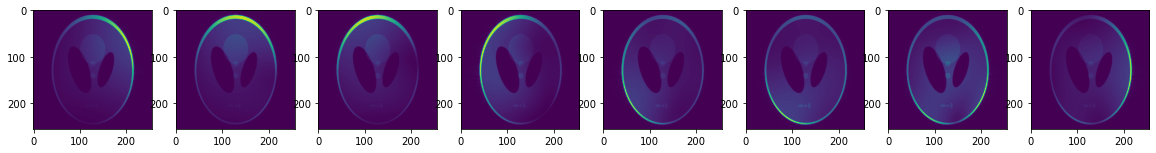

In [4]:
# helper.visualize_seperate_kspaces(kspace)
m_i = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))
fig, axs = plt.subplots(1, 8, squeeze=True)
for i in range(8):
    axs[i].imshow(np.abs(m_i[:, :, i]))

Was fällt bei den Bildern auf? Warum benötigt man mehr als eine Spule?

 * Jede Spule deckt nur einen bestimmten Bereich ab
 * Man braucht mehrere Spulen um alle Bereiche abzudecken

## Aufgabe 2

Die einfachste Möglichkeit, die Bilder zusammenzuführen ist über den Sum-of-Squares-Ansatz. Sei $m_{i}(x, y)$ das rekonstruierte Bild der $i$-ten Spule, dann wird das kombinierte Bild $m(x,y)$ aus den Bildern der einzelnen Spulen wie folgt berechnet:
$$
m(x,y) = \sqrt{\sum_i |m_{i}(x,y)|^2}
$$

Berechnen Sie das Bild, das durch diese Methode entsteht und visualisieren Sie es.

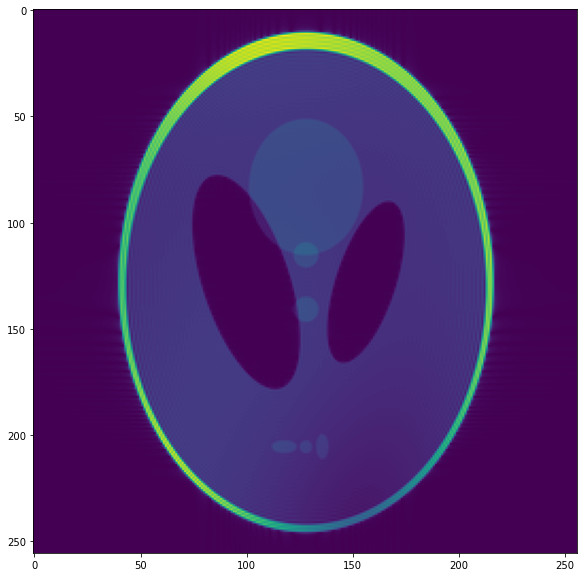

In [5]:
m_i = np.fft.ifftshift(np.fft.ifft2(kspace, axes=(0, 1)), axes=(0, 1))
m_sos = np.sqrt(np.sum(np.abs(m_i) ** 2, 2))
plt.imshow(m_sos)

Was könnten Vor- und Nachteile dieser Methode sein? Warum nimmt man das Betragsquadrat und summiert nicht einfach direkt entlang der Spulen-Dimension?

* Die Sensitivtät wird der Spulen wird nicht berücksichtigt
* Schlechteres SMR (Signal zu Rauschverhältnis)

## Aufgabe 3

Für einige Anwendungen in der MR-Bildgebung benötigt man Karten der räumlichen Sensitivität der einzelnen Spulen. Ein einfacher Ansatz, um die Sensitivitätskarte $C_i(x,y)$ der $i$-ten Spule zu berechnen funktioniert wie folgt:
$$
C_i(x,y) = \frac{m_{i}(x,y)}{\sqrt{\sum_j |m_{j}(x,y)|^2}}
$$

Außerdem müssen die Sensitivitätskarten stark geglättet werden, da sich die Sensitivitäten recht langsam räumlich ändern.

Berechnen Sie die Sensitivitätskarten für alle Spulen und visualisieren Sie diese.

Tipp: Für die Glättung gibt es eine recht einfache Möglichkeit. Denken Sie an die Aufgaben auf dem letzten Notebook zurück.


(256, 256, 8)
(256, 256, 8)


<ipython-input-8-1de671e7db72>:4: RuntimeWarning: invalid value encountered in true_divide
  c_i = m_i_filtered / np.sqrt(np.sum(np.abs(m_i_filtered) ** 2, 2))[:, :, None]


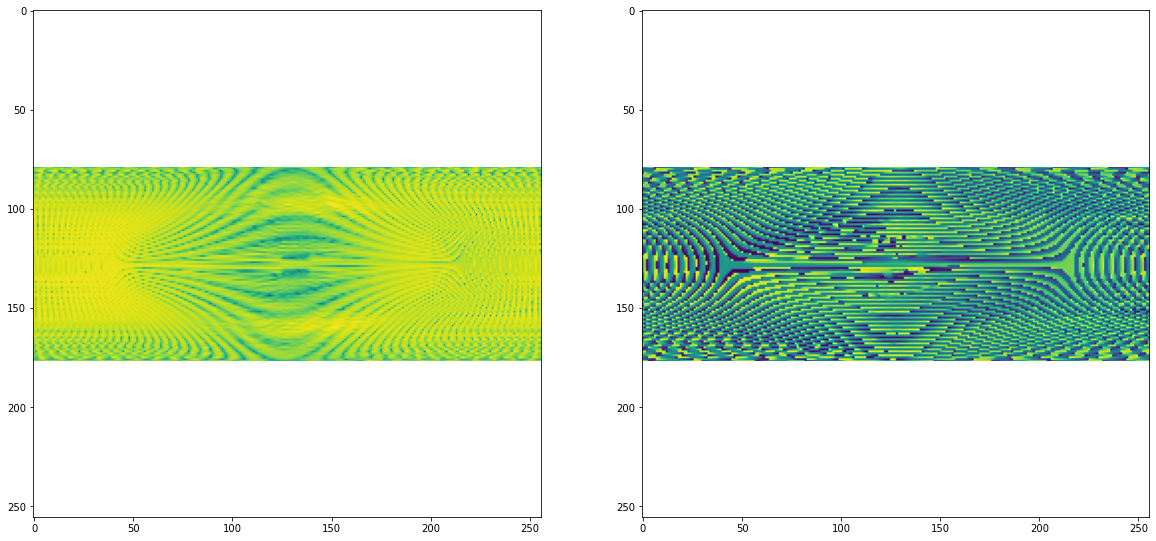

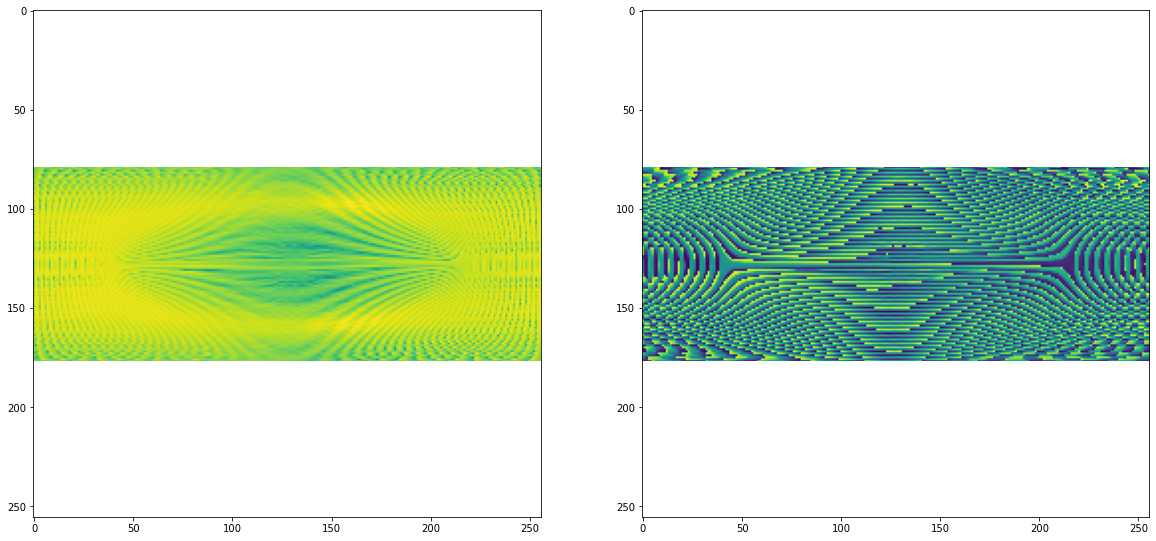

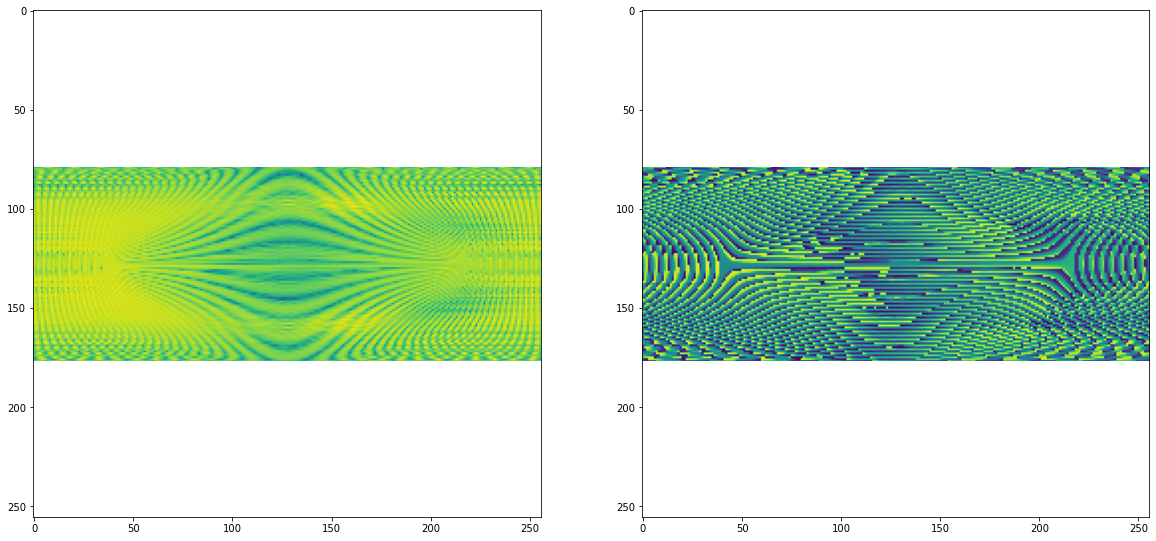

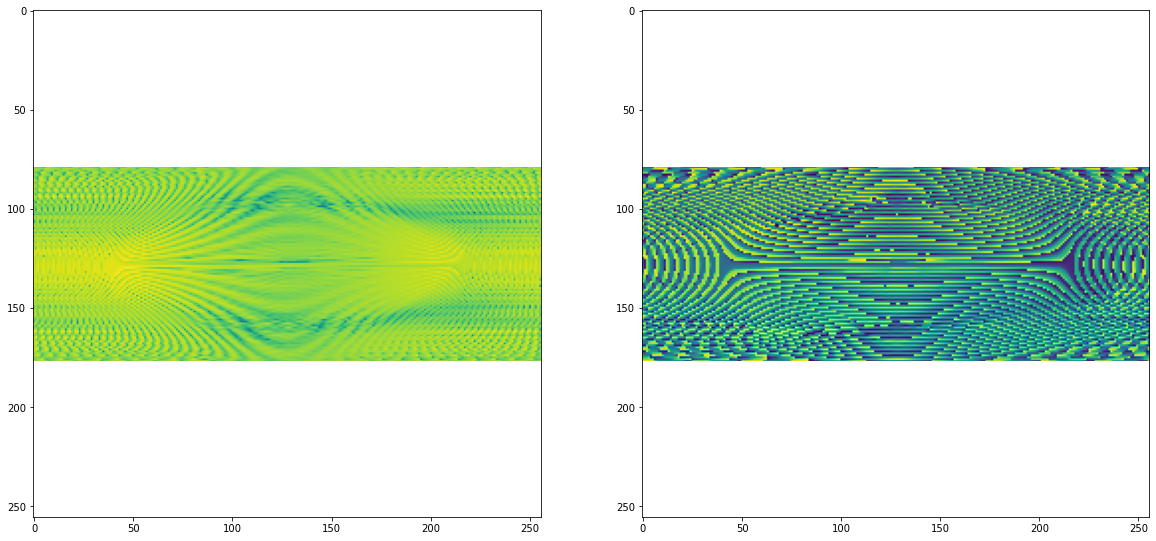

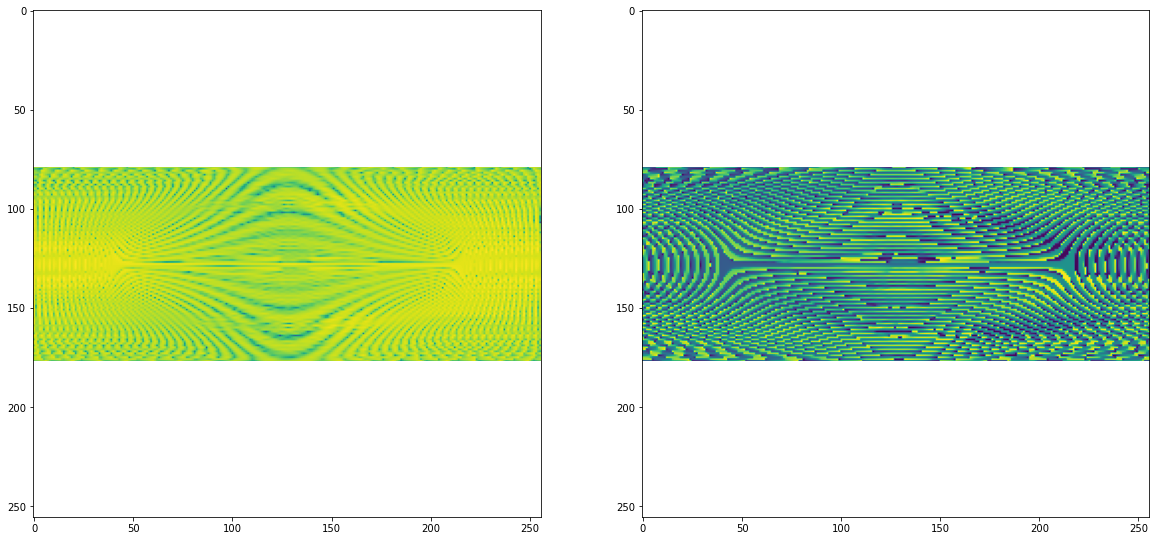

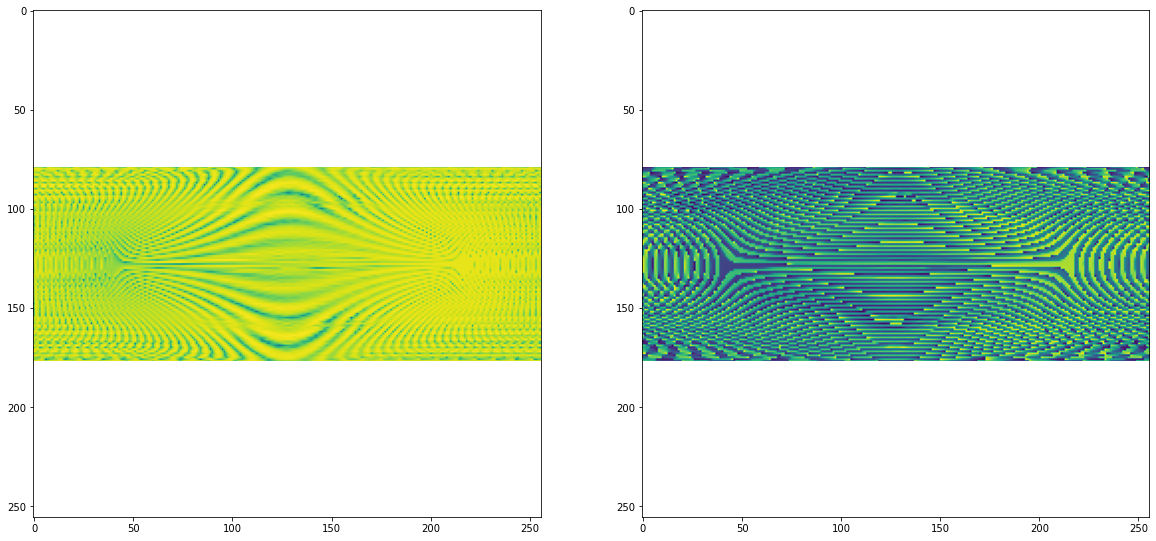

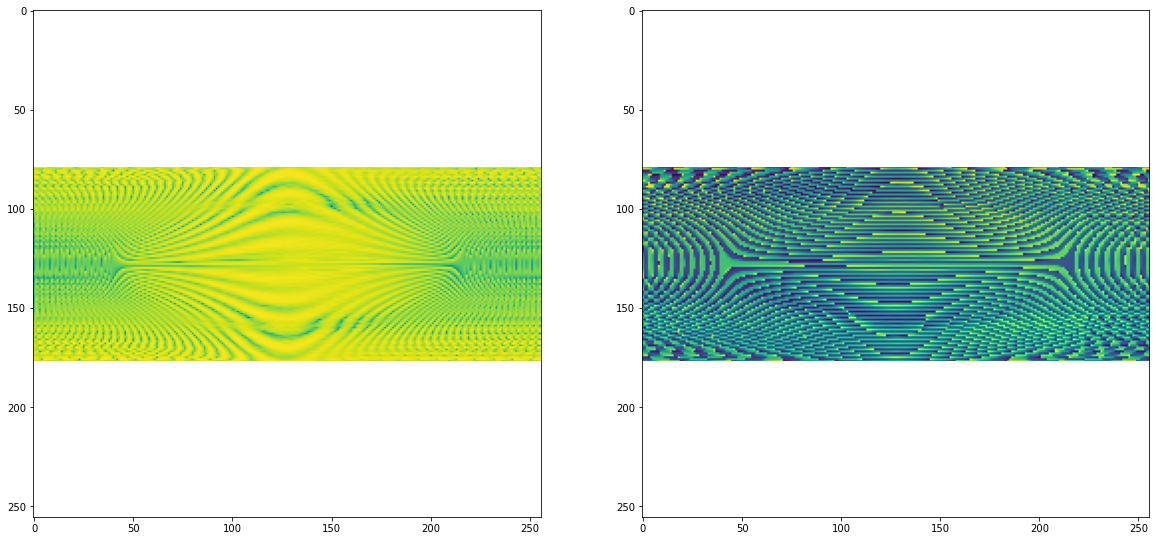

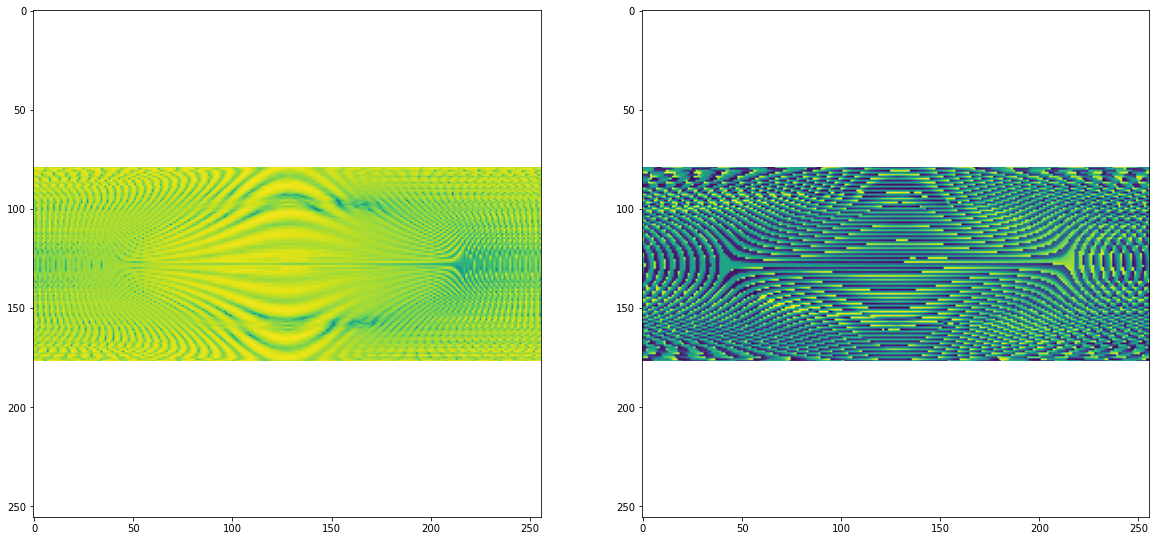

In [8]:
m_i_filtered = helper.ifft(helper.zero_outside_circle(kspace, 50))
print(m_i_filtered.shape)
# c_i = m_i / m_sos[:, :, None]
c_i = m_i_filtered / np.sqrt(np.sum(np.abs(m_i_filtered) ** 2, 2))[:, :, None]
print(c_i.shape)
helper.visualize_seperate_kspaces(c_i)

Was fällt bei den Sensitivitätskarten auf?

* Die groben Formen sind erkennbar
* Für jede Spule ist ein Bereich besonders sensitiv
    * Dieser Bereich rotiert gegen den Uhrzeigersinn um ungefähr pi/4
* In den äußeren Bereichen gibt es hohe Sensitivitäten (was keinen Sinn ergibt)
    * Der Nenner ist in den Bereichen sehr klein
    * Gegenmaßnahme einen Bias auf den Nenner addieren

## Aufgabe 4

Mithilfe der Spulensensitivitäten lässt sich eine andere Methode verwenden, um die Bilder der einzelnen Spulen zu kombinieren, die Weighted-Sums-Methode:

$$
m(x,y) = \frac{\sum_i C_i^\ast \cdot m_i(x,y)}{\sum_j |C_j(x,y)|^2}
$$

$\ast$ steht für die komplexe Konjugation

Verwenden Sie nun diese Methode, um die Spulen zu kombinieren und visualisieren Sie das Ergebnis.

(256, 256)


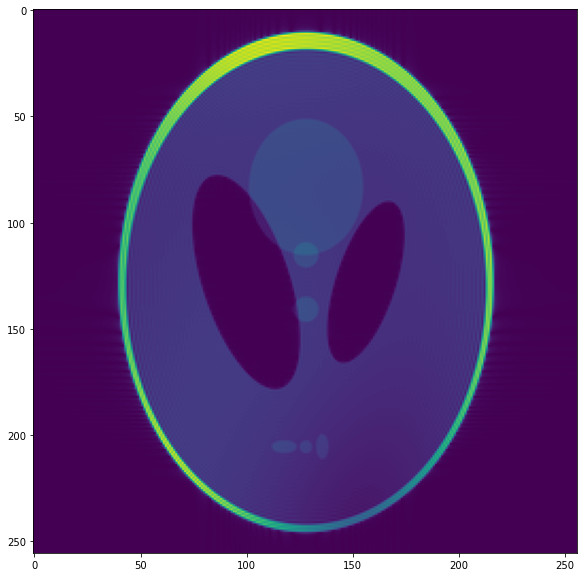

In [9]:
m_ws = np.sum(c_i.conj() * m_i, 2) / np.sum(np.abs(c_i) ** 2, 2)
print(m_ws.shape)
plt.imshow(np.abs(m_ws))

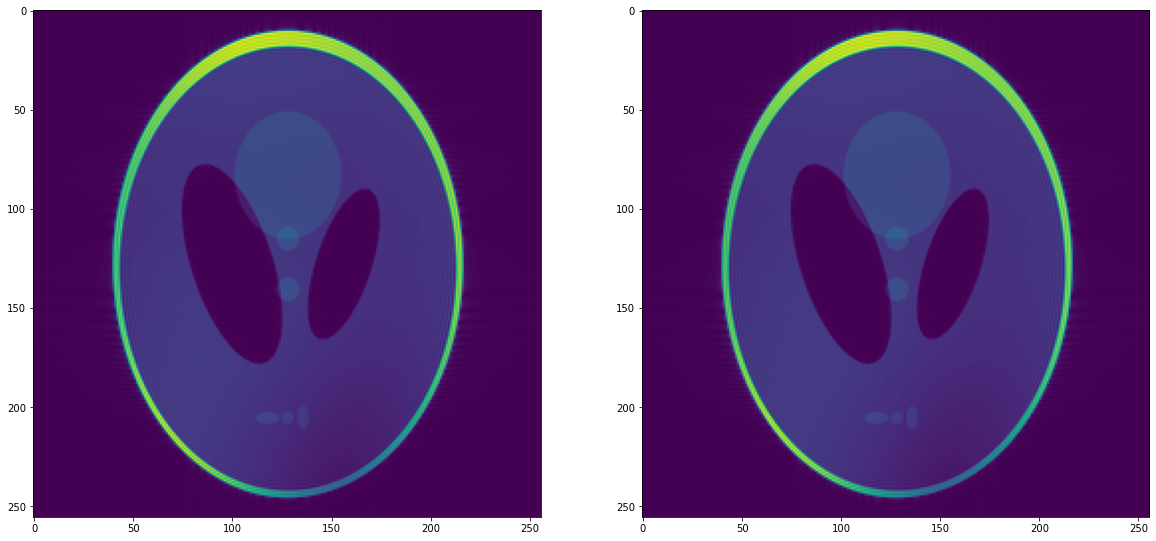

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(m_sos)
axs[1].imshow(np.abs(m_ws))

Worin unterscheidet sich diese Methode von der Sum-Of-Squares-Methode? Was sind Vor- und Nachteile?

* Diese Methode benutzt die Sum-Of-Squares Methode in der Berechnung gewichtet nach der Sensitivät
* Bei Sum-Of-Squares geht die Phaseninformation verloren
    * Wichtig bei Temperaturunterschieden von Wasser
* Falls die Sensitivität der Spulen sehr von einander abweichen kann die Gewichtung nach der Sensitivtät dem entgegenwirken.